In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
recalc_meds = True #recalculate the groupwise median stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
#epoch_db = h5py.File('../imaging_post_processing/epoch_db.hdf5','a')
epoch_db = h5py.File('../02_imaging_post_processing/epoch_db_nnls_fits_bk_sub_F.hdf5','a')

In [3]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])

In [4]:
data['flt_samples'] = np.array(epoch_db['flt_samples'])

In [5]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [7]:
def fly_medians(data,mask):
    """ Calculate the median and percentiles for each type 
    of trial - return in a dictionary keyed by signal and trial """
    #baseline_epoch = (xi >5) & (xi < 7)
    import group_data as gd
    reload(gd)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = dict()
            for fly in fly_set:
                
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            (data['flt_samples'] > 800) & \
                            mask
                            
                if sum(selection) >0:
                    #print 'here'
                    #subplot(3,1,1)
                    datamtrx = data['signal_data'][selection,:]
                    #subplot(3,1,2)
                    #imshow(datamtrx, aspect = 'auto')
                    xi = get_xio(trial)
                    baseline_epoch = (xi >-3) & (xi < 0)
                    baseline = np.nanmean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                    #datamtrx = (datamtrx-baseline[:,np.newaxis])/baseline[:,np.newaxis]
                    datamtrx -= baseline[:,np.newaxis] #delta F
                    #datamtrx /= baseline[:,np.newaxis] # over F
                    #subplot(3,1,3)
                    #imshow(datamtrx,aspect = 'auto')
                    trnsfm = gd.signal_plot_info[signal]['transform']
                    ave_dict[signal][trial][fly] = trnsfm(np.nanmedian(datamtrx,axis = 0))
    return ave_dict

In [8]:
import group_data as gd
trial_types = set(data['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
#fly_set = set(gd.GMR22H05_list) | set(gd.GMR22H05_pr_list) | set(gd.GMR22H05_prc_list)
fly_set = set(gd.GMR40D04_pr_list)

In [9]:
#mask out the data so only the trial types in test_set will be included
mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (data['trial_names'] == trial_name)

#now mask out the data to only include the flys in fly_set
fly_mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for fly in fly_set:
    fly_mask = fly_mask | (data['fly_numbers'] == fly)
mask = mask & fly_mask
#data['trial_names'] == list(test_set)[0])

In [10]:
import cPickle
if recalc_meds:
    meds = fly_medians(data,mask)
    with open('med_dict.cpkl','wb') as fi: cPickle.dump(meds,fi)
else:
    with open('med_dict.cpkl','rb') as fi: meds = cPickle.load(fi)

/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:662: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [11]:
def get_percentiles(signal_name = 'wb_frequency',trial_set = test_set,epoch = (0,3),trial_name = None):
    data_array = np.vstack([np.array(meds[signal_name][trial_name].values()) for trial_name in trial_set])
    xi = get_xio(trial_name)
    epoch_mask = (xi > epoch[0]) & (xi < epoch[1])
    percentile_rng = arange(0,100,1)
    percentiles = [np.nanpercentile(data_array[:,epoch_mask],d) for d in percentile_rng]
    return percentiles,percentile_rng

In [12]:
def kill_spines():
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]

In [13]:
###################
###################
## The Following code is for figure 4. 
## Fitting the smoothed curves
###################
###################

In [14]:
def get_tuning(meds,signal,keylist,sumfun = None):
    xi = np.linspace(0,23,1150) - 7.0
    epoch = (xi >0) & (xi<3)
    tcurve = dict()
    for key in keylist:
        data = np.array(meds[signal][key].values())
        me = np.nanpercentile(sumfun(data[:,epoch]),50,axis = 0)
        ub = np.nanpercentile(sumfun(data[:,epoch]),75,axis = 0)
        lb = np.nanpercentile(sumfun(data[:,epoch]),25,axis = 0)
        tcurve[key] = [me,ub,lb]
    return tcurve

def peaks(x):
    idx = squeeze(argmax(np.abs(x),axis =1))
    peaks = diag(x[:,idx])
    return peaks

def integrals(x):
    return np.sum(x,axis = 0)

In [79]:
# Find the least squares fit to the phases, load the data into the dictionary 'fits'
signal_plot_list = ['Ph1','hg4','hg3']
nms = ['pth_roll_%s'%p for p in range(0,360,30)] #key names
phases = [np.deg2rad(p) for p in range(0,360,30)] #phases for fitting
A = np.array([[1,
               cos(1*p),sin(1*p),
               cos(2*p),sin(2*p),
               cos(3*p),sin(3*p)] for p in phases]) #design matrix

A_pinv = pinv(A)

fits = dict()
tuning_data = dict()
null_distributions_coef = dict()
null_distributions_res = dict()

for signal_name in signal_plot_list:
    data_list = list() #list of data to be fitted
    for i,nm in enumerate(nms):
        xi = get_xio(nm)
        baseline = (xi>-3) & (xi<0)
        selection = (xi>0) & (xi<3)
        baselines = np.array([np.mean(sig[baseline]) for sig in meds[signal_name][nm].values()])
        responses = np.array([np.mean(sig[selection]) for sig in meds[signal_name][nm].values()])
        data_list.append(responses-baselines)
    data_mtrx = np.array(data_list).T
    tuning_data[signal_name] = data_mtrx
    coef_list = list() #list of fitted coef.
    for trial in range(shape(data_mtrx)[0]):
        coef_list.append(dot(A_pinv,data_mtrx[trial,:]))
    fits[signal_name] = coef_list

In [80]:
def resample_rows(x):
    ## create a bootstraped data-set by reshufling the rows of x
    return np.array([i[np.array(random_integers(0,2,shape(x)[1]))] for i in x])

def random_rotate(x):
    ## create a bootstraped data-set by randomly rotating the rows of x
    return np.array([np.roll(i,random_integers(shape(i)[0])) for i in x])

def random_negate(x):
    ## create a bootstraped data-set by randomly flipping the sign of x
    negate_mtrx = ones_like(x) - random_integers(0,1,shape(x))*2
    return x*negate_mtrx

def fourier(p,x):
    return x[0] + \
           x[1]*cos(1*p) + x[2]*sin(1*p) + \
           x[3]*cos(2*p) + x[4]*sin(2*p) + \
           x[5]*cos(3*p) + x[6]*sin(3*p)
            
for signal_name,data_mtrx in tuning_data.items():
    null_distributions_coef[signal_name] = list()
    null_distributions_res[signal_name] = list()
    for resamp in range(20000):
        coef_list = list()
        resamp_mtrx =  random_rotate(data_mtrx)
        for trial in range(shape(resamp_mtrx)[0]):
            coef_list.append(dot(A_pinv,resamp_mtrx[trial,:]))
        null_distributions_coef[signal_name].append(np.array(coef_list))

In [81]:
def calc_grand_sse(coef_mtrx):
    sse_list = list()
    cmean = mean(coef_mtrx,axis = 0)
    ymean = np.array([fourier(p,cmean) for p in phases])
    for cfit in coef_mtrx:
        y = np.array([fourier(p,cfit) for p in phases])
        sse_list.append(np.sum(np.sqrt(np.square(y-ymean))))
    return np.mean(sse_list)

In [82]:
sse_null_dict = dict()
for key in null_distributions_coef.keys():
    print key
    grand_sse = list()
    for reshuf in null_distributions_coef[key]:
        grand_sse.append(calc_grand_sse(reshuf))
    sse_null_dict[key] = np.array(grand_sse)

Ph1
hg4
hg3


In [85]:
def p_val(fit_sse,null_sse):
    hist(null_sse,100)
    axvline(fit_sse)
    return 1-sum(np.array(null_sse)>fit_sse)/float(len(null_sse))

0.28979999999999995

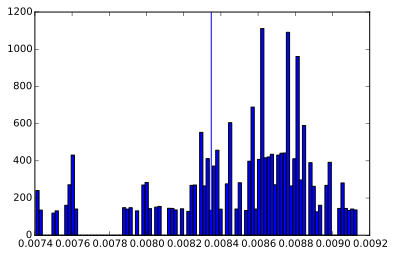

In [87]:
muscle = 'hg3'
p_val(calc_grand_sse(fits[muscle]),sse_null_dict[muscle])

In [88]:
def get_pvals_coef(skey):
    """get the p-values for each coeficient individualy."""
    null_stat = np.mean(null_distributions[skey],axis =1)
    data_stat = np.mean(fits[skey],axis = 0)
    num_extrema = np.sum(np.abs(null_stat) > np.abs(data_stat),axis = 0)
    pvals = num_extrema / float(shape(null_stat)[0])
    return pvals
    #pvals = np.sum(np.abs(np.mean(null_distributions['b1'],axis =1)) > np.mean(fits['b1'],axis = 0),axis = 0)

In [89]:
### Resample from the data to calculate the confidence intervals around the fits.
resampled_coef = dict()
for skey in fits.keys():
    fit_mtrx = np.array(fits[skey])
    resample_list = list()
    for resample in range(2000):
        retrial_list = list()
        for retrial in range(shape(fit_mtrx)[0]):
            choice_idx = np.random.random_integers(0,shape(fit_mtrx)[0]-1,7)
            choice = diag(fit_mtrx[choice_idx])
            retrial_list.append(choice)
        resample_list.append(np.array(retrial_list))
    resampled_coef[skey] = np.array(resample_list)

In [90]:
### Now resample to calculate the fitted curves.
interp_phases = linspace(0,2*pi,40)
coef_ci_dict = dict()
curve_ci_dict = dict()
for skey in fits.keys():
    curve_list = list()
    coef_list = list()
    for resample in resampled_coef[skey]:
        coef = np.mean(resample,axis = 0)
        coef_list.append(coef)
        curve_list.append([fourier(p,coef) for p in interp_phases])
    curve_ci_dict[skey] = {'lb':np.percentile(np.array(curve_list),2.5,axis = 0),
                           'ub':np.percentile(np.array(curve_list),97.5,axis = 0)}
    coef_ci_dict[skey] = {'lb':np.percentile(np.array(coef_list),2.5,axis = 0),
                          'ub':np.percentile(np.array(coef_list),97.5,axis = 0)}

In [91]:
b_map = plb.cm.Blues_r
i_map = plb.cm.Purples_r
iii_map = plb.cm.Reds_r
hg_map = plb.cm.Oranges_r
tp_map = plb.cm.Greens_r
pr_map = plb.cm.Greens_r
nm_map = plb.cm.Greens_r

ttm_map = plb.cm.Greens_r

dvm_map = plb.cm.bone_r

cvls = {'b1':0.01,'b2':0.2,'b3':0.4,
        'i1':0.01,'i2':0.2,
        'iii1':0.01,'iii3':0.2,'iii24':0.4,
        'hg1':0.01,'hg2':0.2,'hg3':0.4,'hg4':0.6,
        'tpd':0.4,'tpv':0.2,
        'pr':0.01,'nm':0.01,
        'ttm':0.01,
        'dvm':0.5}

clrs = {
        'Ph1':'r',
        'wb_frequency':'g',
        'b1':b_map(cvls['b1']),
        'b2':b_map(cvls['b2']),
        'b3':b_map(cvls['b3']),
        'i1':i_map(cvls['i1']),
        'i2':i_map(cvls['i2']),
        'iii1':iii_map(cvls['iii1']),
        'iii3':iii_map(cvls['iii3']),
        'iii24':iii_map(cvls['iii24']),
        'hg1':hg_map(cvls['hg1']),
        'hg2':hg_map(cvls['hg2']),
        'hg3':hg_map(cvls['hg3']),
        'hg4':hg_map(cvls['hg4']),
        'tpv':tp_map(cvls['tpv']),
        'tpd':tp_map(cvls['tpd']),
        'ttm':ttm_map(cvls['ttm'])}

In [92]:
interp_phases_plot = interp_phases[::-1] + 3*pi/2
interp_phases_plot = mod(interp_phases_plot,2*pi)
interp_idx = argsort(interp_phases_plot)
interp_phases_plot = rad2deg(interp_phases_plot[interp_idx]) - 180

data_phases = arange(0,360,30)
data_phases_plot = data_phases[::-1] + 3*90
data_phases_plot = mod(data_phases_plot,360)
#data_phases_plot = mod(arange(0,360,30) - 90 - 180,360)
data_idx = argsort(data_phases_plot)
data_phases_plot = data_phases_plot[data_idx] - 150
print shape(data_idx)

(12,)


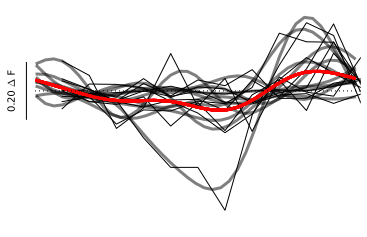

In [93]:
def plot_example_trial(key,showx = False,smin = -0.1,smax = 0.1,lblstr = '%.2f $\Delta$ F'):
    #smin = -0.1;smax = 0.1
    smean = (smin+smax)/2
    slen = smax-smin
    plot([-190,-190],[smin,smax],color = 'k',lw = 2)
    text(-200,smean,lblstr%(slen),rotation = 90,horizontalalignment = 'right',verticalalignment = 'center')
    
    
    interp_phases = linspace(0,2*pi,40)
    
    interp_phases_plot = interp_phases[::-1] + 3*pi/2
    interp_phases_plot = mod(interp_phases_plot,2*pi)
    interp_idx = argsort(interp_phases_plot)
    interp_phases_plot = rad2deg(interp_phases_plot[interp_idx]) - 180
    #interp_phases_plot[interp_idx]
    
    #interp_phases_plot = mod(linspace(0,2*pi,40) - pi/2 - pi,2*pi)
    #interp_idx = argsort(interp_phases_plot)
    
    
    data_phases = arange(0,360,30)
    data_phases_plot = data_phases[::-1] + 3*90
    data_phases_plot = mod(data_phases_plot,360)
    #data_phases_plot = mod(arange(0,360,30) - 90 - 180,360)
    data_idx = argsort(data_phases_plot)
    data_phases_plot = data_phases_plot[data_idx] - 150
    
    for data,fit in zip(tuning_data[key][:10],fits[key][:10]):
        #print shape(data)
        #print(shape(data))
        #print(shape(data_phases_plot))
        plot(data_phases_plot,data[data_idx],color = 'k')
        calc_data = np.array([fourier(p,fit) for p in interp_phases])
        plot(interp_phases_plot,calc_data[interp_idx],color = 'k',lw = 3,alpha = 0.5)
        mean_data = np.array([fourier(p,np.mean(fits[key],axis = 0)) for p in interp_phases])
        plot(interp_phases_plot,mean_data[interp_idx],color = 'r',lw = 3,alpha = 1.0)
    plot([-180,180],[0,0],':',color = 'k')
    gca().set_xbound(-190,180)
    #savefig('example_fit.pdf')
    gca().spines['bottom'].set_position(('outward', 10))
    gca().spines['left'].set_position(('outward', 10))
    kill_spines()
    #[x.set_visible(True) for x in plb.gca().get_yticklabels()]
    #[x.set_visible(True) for x in plb.gca().get_yticklines()[::2]]
    #gca().spines['left'].set_visible(True)
    #print gca().get_ybounds()


    if showx:
        gca().set_xticks(arange(-180,180,30))
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
        gca().spines['bottom'].set_visible(True)
        setp(gca().xaxis.get_majorticklabels(),rotation= 90)
    
    mn,mx = gca().get_ylim()
    rng = mx-mn
    inc = rng/3
    gca().set_yticks(arange(mn,mx+inc,inc))
    
    #savefig('example_fit.pdf')
    #gca().spines['left'].set_position(('outward',2))
    
plot_example_trial('hg4')
#ax = gca()

In [94]:
def plot_muscle_group(group,showx = False,smin = -0.1,smax = 0.1,lblstr = '%.2f $\Delta$ F'):
    
    smean = (smin+smax)/2
    slen = smax-smin
    plot([-190,-190],[smin,smax],color = 'k',lw = 2)
    text(-200,smean,lblstr%(slen),rotation = 90,horizontalalignment = 'right',verticalalignment = 'center')
    
    for skey in group:
        interp_phases = linspace(0,2*pi,40)
        #plot_angles = mod(linspace(0,2*pi,40) - pi/2 - pi,2*pi)
        x = np.mean(fits[skey],axis = 0)
        clr = clrs[skey]
        calc_data = np.array([fourier(p,x) for p in interp_phases])
        plot_phases = interp_phases[::-1]+3*pi/2
        plot_phases = mod(plot_phases,2*pi)
        idx = argsort(plot_phases)
        #lns = plot(rad2deg(plot_angles[idx])-180,calc_data[idx],'r',lw = 2,color = clr)
        lns = plot(rad2deg(plot_phases[idx])-180,calc_data[idx],'r',lw = 2,color = clr)
        ub = curve_ci_dict[skey]['ub']
        lb = curve_ci_dict[skey]['lb']
        fill_between(rad2deg(plot_phases[idx])-180,ub[idx],lb[idx],alpha = 0.2,lw = 0,color = clr)
        kill_spines()
        plot([-180,180],[0,0],':',color = 'k')
        gca().set_xbound(-190,180)
   
    if showx:
        gca().set_xticks(arange(-180,185,30))
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
        gca().spines['bottom'].set_visible(True)
        setp(gca().xaxis.get_majorticklabels(),rotation= 90)
        
def plot_fits(muscle):
    m = np.mean(np.array(fits[muscle]).T,axis = 1)
    ub = coef_ci_dict[skey]['ub']
    lb = coef_ci_dict[skey]['lb']
    clr = clrs[muscle]
    errorbar(np.arange(len(m)),m,yerr = [ub,lb],fmt = 'o',color = clr)
    kill_spines()
    plot([-0.5,6.5],[0,0],color = 'k')
    gca().set_xbound(-0.5,7.5)
    gca().set_ylabel(muscle)
    

In [95]:
def plot_coef(group):
    for i,muscle in enumerate(group):
        m = np.mean(np.array(fits[muscle]),axis = 0)
        ub = m - coef_ci_dict[muscle]['ub'] 
        lb = coef_ci_dict[muscle]['lb'] - m
        clr = clrs[muscle]
        errorbar(np.arange(len(m))*15+i,m,yerr = [ub,lb],fmt = 'o',ms = 2,color = clr)
    plot([-2,100],[0,0],':',color = 'k')
    gca().set_xbound(-2,100)
    kill_spines()

In [96]:
def plot_coef_pvals():
    slist = ['Ph1','wb_frequency','b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
    slist = slist[::-1]
    lbllist = list(slist)
    lbllist[-1] = 'rwing'
    lbllist[-2] = 'wb freq'
    pvals = np.array([get_pvals(skey) for skey in slist])

    plotmtrx = (pvals < 0.005).astype(float)
    plotmtrx += (pvals < 0.001).astype(float)
    plotmtrx += (pvals < 0.0001).astype(float)
    plotmtrx += (pvals < 0.00001).astype(float)
    plotmtrx += (pvals < 0.000001).astype(float)

    pcolor(plotmtrx,cmap = cm.hot,vmin = -1,vmax = 6,edgecolors='w', linewidths=2)
    
    kill_spines()
    [x.set_visible(True) for x in plb.gca().get_yticklabels()]
    [x.set_visible(True) for x in plb.gca().get_yticklines()[::2]]
    gca().spines['left'].set_visible(True)
    [x.set_visible(True) for x in plb.gca().get_xticklabels()]
    [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    gca().spines['bottom'].set_visible(True)
    gca().set_yticks(arange(len(slist))+0.5)
    gca().set_yticklabels(lbllist)
    gca().set_ybound(0,len(slist))
    gca().set_xticks(arange(7)+0.5)
    gca().set_xticklabels(['$a_{0}$','$a_{1}$','$b_{1}$','$a_{2}$','$b_{2}$','$a_{3}$','$b_{3}$'])
    #colorbar()

In [97]:
def roll_coords(axlist):
    """rotate the axes so that the trials are arranged in the stimulus reference frame
    with 0deg pointed in front of the fly"""
    axlist = axlist[::-1]
    idx = range(2,len(axlist))
    idx.extend(range(2))
    axlist = [axlist[x] for x in idx]
    return axlist

In [98]:
def plot_timeser(axlist,sigkey):
    newax = roll_coords(axlist)
    for ax,trialkey in zip(newax,['pth_roll_%s'%(x) for x in arange(0,360,30)]):
        axes(ax)
        xi = get_xio(trialkey)
        time_mask = (xi > -1) & (xi < 6)
        md = np.percentile(meds[sigkey][trialkey].values(),50,axis = 0)
        ub = np.percentile(meds[sigkey][trialkey].values(),75,axis = 0)
        lb = np.percentile(meds[sigkey][trialkey].values(),25,axis = 0)

        fill_between(xi[time_mask],lb[time_mask],ub[time_mask],color = 'k',alpha = 0.6,clip_on = False,lw = 0)
        plot(xi[time_mask],md[time_mask],clip_on = False,color = 'k')
        trial_set = ['pth_roll_%s'%(x) for x in arange(0,360,30)]
        lower,upper = np.array(get_percentiles(sigkey,trial_set= trial_set,epoch = (-3,0))[0])[[1,98]]
        rng = upper-lower
        gca().set_ybound(0-rng*2,0+rng*2)
        gca().set_xbound(-3,6)
        gca().set_axis_bgcolor('none')
        
        kill_spines()

In [99]:
def plot_polar_curves(group):
    interp_phases = linspace(0,2*pi,40)
    #subplot(1,4,4,polar = True)
    for skey in group:
        #gca().set_theta_offset(pi)
        #gca().set_theta_offset(pi)
        curve = np.array([fourier(p,np.mean(fits[skey],axis = 0)) for p in interp_phases])
        curve -= min(curve)
        curve /= max(curve)
        clr = clrs[skey]
        #curve = curve[::-1]
        #plot_phases = interp_phases[::-1]
        plot_phases = interp_phases
        plot(plot_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
        gca().spines['polar'].set_visible(False)
        gca().set_ybound(0,1.1)
        [x.set_visible(False) for x in gca().get_yticklabels()]
        [x.set_visible(False) for x in gca().get_xticklabels()]
        #kill_spines()
        
def plot_polar_data(group):
    for skey in group:
        gca().set_theta_offset(-pi)
        curve = tuning_curves[skey]['me'] - min(tuning_curves[skey]['me'])
        curve = np.concatenate((curve,[curve[0]]))
        curve /= max(curve)
        clr = clrs[skey]
        plot(deg2rad(np.arange(0,390,30)),curve,color = clr,lw = 3,alpha = 0.7)
        gca().spines['polar'].set_visible(False)
        gca().set_ybound(0,1.1)
        [x.set_visible(False) for x in gca().get_yticklabels()]
        [x.set_visible(False) for x in gca().get_xticklabels()]

In [100]:
def show_muscle_image(imfile = 'b_musc.tiff'):
    import tifffile
    img = tifffile.TiffFile('../muscle_segmentation/'+imfile)
    imshow(img.asarray())
    kill_spines()

In [101]:
def plot_time_course_lbl(axlist):
    #angles = range(0,360,30)
    angles = range(-180,185,30)
    for i,ax in enumerate(axlist):
        axes(ax)
        axvspan(0,3,alpha = 0.1,lw=0)
        gca().set_xbound(-3,6)
        kill_spines()
        gca().set_xlabel(u'%s\u00B0'%(angles[i]))

def plot_coef_pvals_lbl():
    pcolor(np.array([[0,1,2,3,4,5]]).T,cmap = cm.hot,vmin = -1,vmax = 6,edgecolors='w', linewidths=2)
    kill_spines()
    #[x.set_visible(True) for x in gca().get_yticklines()[::2]]
    [x.set_visible(True) for x in gca().get_yticklabels()]
    gca().set_yticks(np.arange(6)+0.5)
    gca().set_yticklabels(['$p > 0.05$',
                           '$0.05 > p >0.001$',
                           '$10^{-3} > p > 10^{-4}$',
                           '$10^{-4} > p > 10^{-5}$',
                           '$10^{-5} > p > 10^{-6}$',
                           '$10^{-6} > p$'])

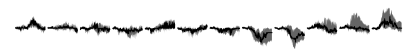

In [102]:
from matplotlib import gridspec
col_width = 5.8
fig = figure(figsize = (col_width*2,6))
gs = gridspec.GridSpec(100,100)
j = 0; inc = 13
time_course_6_axes_list =  [fig.add_subplot(gs[j:j+inc-1, i*5 +12 :i*5+6+12]) for i in range(0,12)]
plot_timeser(time_course_6_axes_list,'hg4')

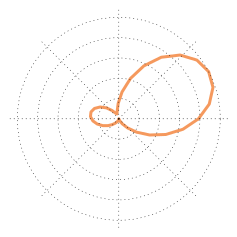

In [103]:
fig = figure()
fig.add_subplot(111,polar = True);
plot_polar_curves(['hg3'])
#savefig('hg4_solo.pdf')

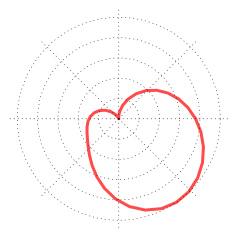

In [51]:
fig = figure()
fig.add_subplot(111,polar = True);
plot_polar_curves(['Ph1'])

In [77]:
fits.keys()

['Ph1', 'hg4']

In [160]:
interp_phases = linspace(0,2*pi,40)

interp_phases_plot = interp_phases[::-1] + 3*pi/2
interp_phases_plot = mod(interp_phases_plot,2*pi)
interp_idx = argsort(interp_phases_plot)
interp_phases_plot = rad2deg(interp_phases_plot[interp_idx]) - 180
#interp_phases_plot[interp_idx]

#interp_phases_plot = mod(linspace(0,2*pi,40) - pi/2 - pi,2*pi)
#interp_idx = argsort(interp_phases_plot)


data_phases = arange(0,360,30)
data_phases_plot = data_phases[::-1] + 3*90
data_phases_plot = mod(data_phases_plot,360)

In [163]:
print interp_phases_plot[-1]

173.076923077


In [162]:
print data_phases_plot[0]

240


/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
/media/analysis-code/flight-muscles/packages/tifffile.py:2170: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


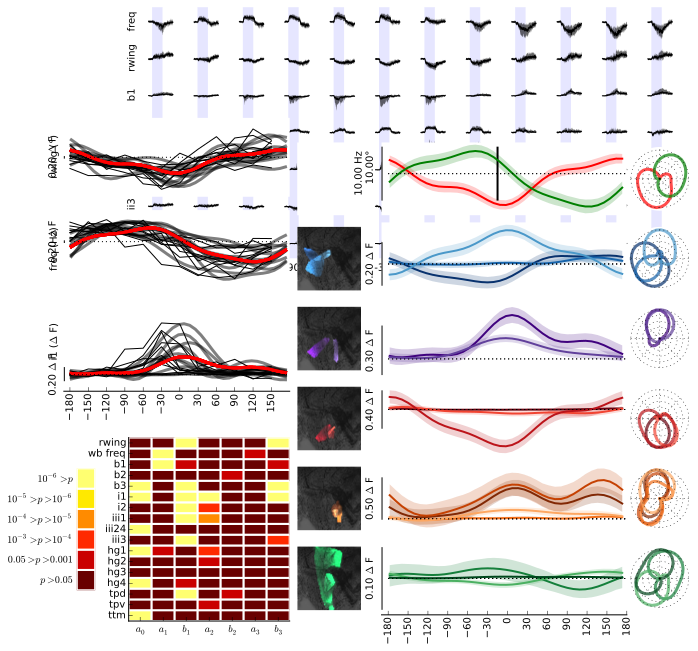

In [96]:
col_width = 5.8
fig = figure(figsize = (col_width*2,11))
gs = gridspec.GridSpec(100,100)

time_course_lb_axes_list = [fig.add_subplot(gs[0:41,  i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_1_axes_list =  [fig.add_subplot(gs[0:5,   i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_2_axes_list =  [fig.add_subplot(gs[6:11,  i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_3_axes_list =  [fig.add_subplot(gs[12:17, i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_4_axes_list =  [fig.add_subplot(gs[18:23, i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_5_axes_list =  [fig.add_subplot(gs[24:29, i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_6_axes_list =  [fig.add_subplot(gs[30:35, i*7 +12 :i*7+5+12]) for i in range(0,12)]
time_course_7_axes_list =  [fig.add_subplot(gs[36:41, i*7 +12 :i*7+5+12]) for i in range(0,12)]

i = 18;inc = 15
example_fit_1_axes =  fig.add_subplot(gs[i:i+inc-2, 0: 35]);i+= inc
example_fit_2_axes =  fig.add_subplot(gs[i:i+inc-2, 0: 35]);i+= inc
example_fit_3_axes =  fig.add_subplot(gs[i:i+inc-2, 0: 35])

coef_summary_axes = fig.add_subplot(gs[70:100, 10: 35])
coef_summary_lb_axes = fig.add_subplot(gs[75:95,2:5])

i = 22;inc = 13
kin_image_axes =    fig.add_subplot(gs[i:i+inc-1,  36:46]); i+= inc
b_image_axes =      fig.add_subplot(gs[i:i+inc-1,  36:46]); i+= inc
i_image_axes =      fig.add_subplot(gs[i:i+inc-1,  36:46]); i+= inc
iii_image_axes =    fig.add_subplot(gs[i:i+inc-1,  36:46]); i+= inc
hg_image_axes =     fig.add_subplot(gs[i:i+inc-1,  36:46]); i+= inc
tp_image_axes =     fig.add_subplot(gs[i:i+inc-1,  36:46]); 

i = 22;inc = 13
kin_curve_axes =    fig.add_subplot(gs[i:i+inc-1,  49:87]); i+= inc
b_curve_axes =      fig.add_subplot(gs[i:i+inc-1,  49:87]); i+= inc
i_curve_axes =      fig.add_subplot(gs[i:i+inc-1,  49:87]); i+= inc
iii_curve_axes =    fig.add_subplot(gs[i:i+inc-1,  49:87]); i+= inc
hg_curve_axes =     fig.add_subplot(gs[i:i+inc-1,  49:87]); i+= inc
tp_curve_axes =     fig.add_subplot(gs[i:i+inc-1,  49:87]); 

i = 22;inc = 13
kin_polar_axes =    fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); i+= inc
b_polar_axes =      fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); i+= inc
i_polar_axes =      fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); i+= inc
iii_polar_axes =    fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); i+= inc
hg_polar_axes =     fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); i+= inc
tp_polar_axes =     fig.add_subplot(gs[i:i+inc-1,  87:97],polar = True); 

#################
#################

plot_timeser(time_course_1_axes_list,'wb_frequency')
axes(time_course_1_axes_list[0])
gca().set_ylabel('freq')

plot_timeser(time_course_2_axes_list,'Ph1')
axes(time_course_2_axes_list[0])
gca().set_ylabel('rwing')

plot_timeser(time_course_3_axes_list,'b1')
axes(time_course_3_axes_list[0])
gca().set_ylabel('b1')

plot_timeser(time_course_4_axes_list,'b3')
axes(time_course_4_axes_list[0])
gca().set_ylabel('b3')

plot_timeser(time_course_5_axes_list,'i1')
axes(time_course_5_axes_list[0])
gca().set_ylabel('i1')

plot_timeser(time_course_6_axes_list,'iii3')
axes(time_course_6_axes_list[0])
gca().set_ylabel('iii3')

plot_timeser(time_course_7_axes_list,'hg1')
axes(time_course_7_axes_list[0])
gca().set_ylabel('hg1')

plot_time_course_lbl(time_course_lb_axes_list)

axes(example_fit_1_axes)
gca().set_ylabel(u'rwing (\u00B0)')
plot_example_trial('Ph1')

axes(example_fit_2_axes)
gca().set_ylabel('freq (Hz)')
plot_example_trial('wb_frequency')

axes(example_fit_3_axes)
gca().set_ylabel('i1 ($\Delta$ F)')
plot_example_trial('i1',showx=True)

axes(coef_summary_axes)
plot_coef_pvals()
axes(coef_summary_lb_axes)
plot_coef_pvals_lbl()

axes(kin_image_axes)
kill_spines()
axes(b_image_axes)
show_muscle_image('b_musc.tiff')
axes(i_image_axes)
show_muscle_image('i_musc.tiff')
axes(iii_image_axes)
show_muscle_image('iii_musc.tiff')
axes(hg_image_axes)
show_muscle_image('hg_musc.tiff')
axes(tp_image_axes)
show_muscle_image('t_musc.tiff')

axes(kin_curve_axes)
plot([-15,-15],[-5,5],color = 'k',lw = 2)
plot_muscle_group(['Ph1','wb_frequency'],smin = -5,smax = 5,lblstr = u'%.2f Hz\n10.00\u00B0   ')

axes(b_curve_axes)
plot_muscle_group(['b1','b2','b3'],smin = -0.1,smax = 0.1,lblstr = '%.2f $\Delta$ F')

axes(i_curve_axes)
plot_muscle_group(['i1','i2'],smin = -0.1,smax = 0.2,lblstr = '%.2f $\Delta$ F')

axes(iii_curve_axes)
plot_muscle_group(['iii1','iii24','iii3'],smin = -0.2,smax = 0.2,lblstr = '%.2f $\Delta$ F')

axes(hg_curve_axes)
plot_muscle_group(['hg1','hg2','hg3','hg4'],smin = -0.0,smax = 0.5,lblstr = '%.2f $\Delta$ F')

axes(tp_curve_axes)
plot_muscle_group(['tpv','tpd','ttm'],showx = True,smin = -0.05,smax = 0.05,lblstr = '%.2f $\Delta$ F')

axes(kin_polar_axes)
plot_polar_curves(['Ph1','wb_frequency'])
axes(b_polar_axes)
plot_polar_curves(['b1','b2','b3'])
axes(i_polar_axes)
plot_polar_curves(['i1','i2'])
axes(iii_polar_axes)
plot_polar_curves(['iii1','iii24','iii3'])
axes(hg_polar_axes)
plot_polar_curves(['hg1','hg2','hg3','hg4'])
axes(tp_polar_axes)
plot_polar_curves(['tpv','tpd','ttm'])
savefig('tuning_curves.pdf')

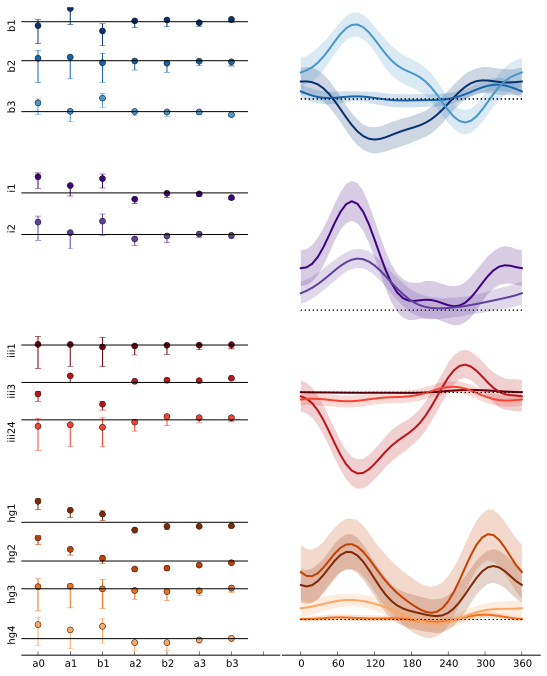

In [59]:
gs = gridspec.GridSpec(16,2)
figure(figsize = (8,10))
   
subplot(gs[0:4,1])
plot_muscle_group(['b1','b2','b3'])
subplot(gs[0,0])
plot_fits('b1')
subplot(gs[1,0])
plot_fits('b2')
subplot(gs[2,0])
plot_fits('b3')

subplot(gs[4:8,1])
plot_muscle_group(['i1','i2'])
subplot(gs[4,0])
plot_fits('i1')
subplot(gs[5,0])
plot_fits('i2')

subplot(gs[8:12,1])
plot_muscle_group(['iii1','iii3','iii24'])
subplot(gs[8,0])
plot_fits('iii1')
subplot(gs[9,0])
plot_fits('iii3')
subplot(gs[10,0])
plot_fits('iii24')

subplot(gs[12:16,1])
plot_muscle_group(['hg1','hg2','hg3','hg4'])
ax = gca()#
#ax.set_xticklabels(['','a0','a1','b1','a2','b2','a3','b3',''])

gca().spines['bottom'].set_visible(True)
gca().set_xticks(range(0,390,60))
[x.set_visible(True) for x in plb.gca().get_xticklabels()]
[x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
#subplots_adjust(wspace = 0.01,hspace = 0.01,left = 0 ,right = 1,top = 1,bottom = 0)

subplot(gs[12,0])
plot_fits('hg1')
subplot(gs[13,0])
plot_fits('hg2')
subplot(gs[14,0])
plot_fits('hg3')
subplot(gs[15,0])
plot_fits('hg4')

ax = gca()#
ax.set_xticklabels(['','a0','a1','b1','a2','b2','a3','b3',''])
gca().spines['bottom'].set_visible(True)
[x.set_visible(True) for x in plb.gca().get_xticklabels()]
[x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
subplots_adjust(wspace = 0.01,hspace = 0.05,left = 0.05 ,right = 0.95,top = 0.95,bottom = 0.05)

savefig('tuning_curves.pdf')

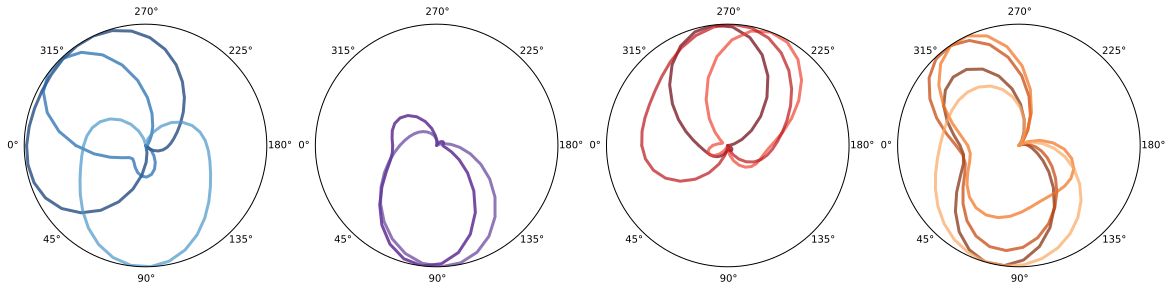

In [60]:
xpnts = zeros_like(interp_phases)

figure(figsize = (20,10))
subplot(1,4,1,polar = True)
gca().set_theta_offset(-pi)
curve = np.array([fourier(p,np.mean(fits['b1'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['b1']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)


curve = np.array([fourier(p,np.mean(fits['b2'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['b2']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)


curve = np.array([fourier(p,np.mean(fits['b3'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['b3']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)
[x.set_visible(False) for x in plb.gca().get_yticklabels()]
gca().grid(False)

######
######
subplot(1,4,2,polar = True)
gca().set_theta_offset(-pi)
curve = np.array([fourier(p,np.mean(fits['i1'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['i1']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)


curve = np.array([fourier(p,np.mean(fits['i2'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['i2']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)
[x.set_visible(False) for x in plb.gca().get_yticklabels()]
gca().grid(False)

#####
#####

subplot(1,4,3,polar = True)
gca().set_theta_offset(-pi)
curve = np.array([fourier(p,np.mean(fits['iii1'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['iii1']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)

curve = np.array([fourier(p,np.mean(fits['iii24'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['iii24']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)

curve = np.array([fourier(p,np.mean(fits['iii3'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['iii3']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)
[x.set_visible(False) for x in plb.gca().get_yticklabels()]
gca().grid(False)

#####
#####

subplot(1,4,4,polar = True)
gca().set_theta_offset(-pi)
curve = np.array([fourier(p,np.mean(fits['hg1'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['hg1']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)

curve = np.array([fourier(p,np.mean(fits['hg2'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['hg2']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)

curve = np.array([fourier(p,np.mean(fits['hg3'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['hg3']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)


curve = np.array([fourier(p,np.mean(fits['hg4'],axis = 0)) for p in interp_phases])
curve -= min(curve)
curve /= max(curve)
clr = clrs['hg4']
plot(interp_phases,curve-min(curve),color = clr,lw = 3,alpha = 0.7)
#fill_between(interp_phases,xpnts,curve,color = clr,alpha = 0.1)
[x.set_visible(False) for x in plb.gca().get_yticklabels()]
gca().grid(False)
savefig('polar_plots.pdf')

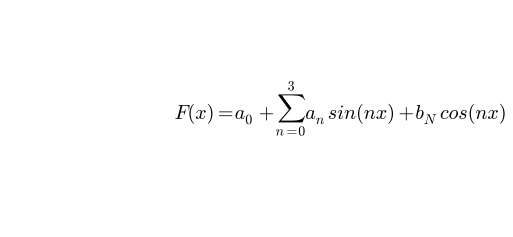

In [168]:
figure()
subplot(1,1,1)
text(0.5,0.5,u'$F(x) = a_0 + \sum_{n=0}^3 a_n sin(nx) + b_N cos(nx) $',size = 20)
kill_spines()
plb.rcParams['pdf.fonttype'] = 3
savefig('equn.pdf')
plb.rcParams['pdf.fonttype'] = 42

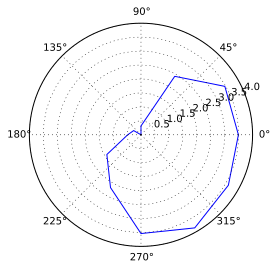

In [227]:
signal = 'b1'
curve = tuning_curves[signal]['me'] - min(tuning_curves[signal]['me'])
curve = np.concatenate((curve,[curve[0]]))
plot(deg2rad(np.arange(0,390,30)),curve)

In [192]:
tuning_curves = dict()
for signal in signal_plot_list:
    keylist = ['pth_roll_' + str(p) for p in range(0,360,30)]
    tc = get_tuning(meds,signal,keylist,sumfun = integrals)
    me = np.array([tc[k][0] for k in keylist])
    ub = np.array([tc[k][1] for k in keylist])
    lb = np.array([tc[k][2] for k in keylist])
    tuning_curves[signal] = {'me':me,'ub':ub,'lb':lb}

In [16]:
def get_activation_profile(pole):
    idx = argwhere(pole == np.arange(0,360,30))
    profile = dict()
    for muscle in ['b1','b2','b3',
                   'i1','i2',
                   'iii1','iii3','iii24',
                   'hg1','hg2','hg3','hg4',
                   'tpd','tpv','ttm']:
        profile[muscle] = tuning_curves[muscle]['me'][idx]
    return profile

In [17]:
import h5py
#model_data = h5py.File(gd.muscle_anatomy_dir + 'flatened_model.hdf5','r')
model_data = h5py.File(gd.muscle_anatomy_dir + 'max_imgs.h5py')

In [18]:
def get_actv_img(angle):
    actv_profile = get_activation_profile(angle)
    img = np.sum([np.array(model_data[key])/(255.0)*actv_profile[key] for key in actv_profile.keys()],axis = 0)
    return img

In [19]:
stim_angles = np.arange(0,360,30)
movie = [get_actv_img(angle) for angle in stim_angles]

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-0.523598775598
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-1.0471975512
-

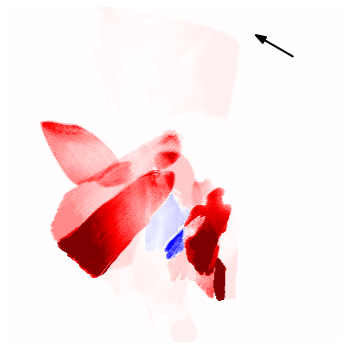

In [46]:
from matplotlib import animation

i=0
fig = figure(figsize = (6,6))
gs_img = gridspec.GridSpec(1,1)
gs_inset = gridspec.GridSpec(3,3)

ax_img = fig.add_subplot(gs_img[0,0])
img = imshow(movie[i],cmap = cm.seismic,vmin = -2.0,vmax = 2.0)
kill_spines()
ax_inset = fig.add_subplot(gs_inset[0,2])
ref_vec = [-1,0]
stim_vec = ref_vec
arrow = ax_inset.arrow(0,0,stim_vec[0],stim_vec[1],head_width = 0.2,lw = 2.0,fc = 'k',ec='k')
ref_pnts = arrow.xy
ax_inset.set_ybound(-1.5,1.5)
ax_inset.set_xbound(-1.5,1.5)
kill_spines()


def animate(i):
    theta = deg2rad(stim_angles[i])*-1
    #print theta
    R = np.array([[cos(theta),-1*sin(theta)],[sin(theta),cos(theta)]])
    xy = dot(ref_pnts,R)
    img.set_data(movie[i])
    arrow.set_xy(xy)
    

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter 
Writer = FFMpegWriter 
writer = Writer(fps=33, metadata=dict(artist='Theodore Lindsay'), bitrate=1800)

frames = np.arange(len(stim_angles))
frames = sort(tile(frames,30))

ani = animation.FuncAnimation(fig, animate, frames=frames, blit=False)
ani.save('tuning_maps.mp4', writer=writer)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 11

In [22]:
frames

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

(466, 1150)


"\nsignal_name = 'b2'\ntrial_name = 'flow_left'\ndeciles = get_deciles(signal_name = signal_name,trial_set = test_set)\nplot(deciles,linspace(0,1,100))\n\n\nsignal_name = 'iii1'\ntrial_name = 'flow_left'\ndeciles = get_deciles(signal_name = signal_name,trial_set = test_set)\nplot(deciles,linspace(0,1,100))\n\nsignal_name = 'i1'\ntrial_name = 'flow_left'\ndeciles = get_deciles(signal_name = signal_name,trial_set = test_set)\nplot(deciles,linspace(0,1,100))\n"

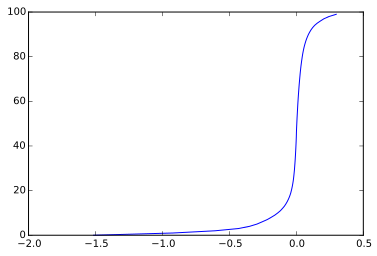

In [232]:
signal_name = 'b1'
trial_name = 'flow_left'
percentiles = get_percentiles(signal_name = signal_name,trial_set = test_set)
#gca().axhspan(0.05,0.95,alpha = 0.2)
plot(*percentiles)

"""
signal_name = 'b2'
trial_name = 'flow_left'
deciles = get_deciles(signal_name = signal_name,trial_set = test_set)
plot(deciles,linspace(0,1,100))


signal_name = 'iii1'
trial_name = 'flow_left'
deciles = get_deciles(signal_name = signal_name,trial_set = test_set)
plot(deciles,linspace(0,1,100))

signal_name = 'i1'
trial_name = 'flow_left'
deciles = get_deciles(signal_name = signal_name,trial_set = test_set)
plot(deciles,linspace(0,1,100))
"""

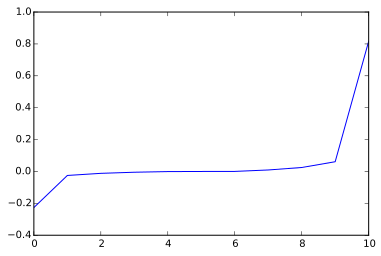

In [178]:
axvspan(5,95)

In [164]:
plot(get_deciles(signal_name = signal_name,trial_name = trial_name,epoch = (0,3)))
plot(get_deciles(signal_name = signal_name,trial_name = trial_name,epoch = (-3,0)))

TypeError: get_deciles() got an unexpected keyword argument 'trial_name'

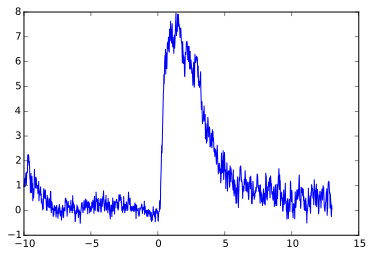

In [136]:
trial_type = 'descending'
xi = get_xio(trial_type)
plot(xi,np.median(np.array(meds['wb_frequency'][trial_type].values()),axis = 0))

In [27]:
import transformations as tran

/media/analysis-code/flight-muscles/packages/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [31]:
tran.translation_matrix([1,0,0,0])

array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [38]:
tran.rotation_matrix(pi/2.0,[1,0,0,0])

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   6.12323400e-17,  -1.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   6.12323400e-17,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [256]:
10*5.0

50.0

37.5